# Mask R-CNN Species Photogrammetry

### Environment Setup

In [3]:
import os
import sys
import random
import cv2
import math
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug import augmenters as iaa
import numpy.ma as ma
import scipy.misc
import skimage.filters

# Root directory of the project
MASK_RCNN_DIR = os.path.abspath("../Mask_RCNN/")
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import whale_stable as whale

%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.abspath("../Mask_RCNN/logs/")


Using TensorFlow backend.


### Model and dataset setup

In [4]:
config = whale.WhaleConfig()
WHALE_DIR = os.path.abspath("../photogram_data/")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
# Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0" # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"




In [5]:
# Load dataset to measure
dataset = whale.WhaleDataset()
dataset.load_whale(WHALE_DIR, "test")
#dataset.load_whale(WHALE_DIR, "test")

# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 62
Classes: ['BG', 'balaenoptera_musculus_body', 'balaenoptera_musculus_pectoral', 'megaptera_novaeangliae_body', 'megaptera_novaeangliae_pectoral', 'balaenoptera_acutorostrata_body', 'balaenoptera_acutorostrata_pectoral']


In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                          config=config)

## Function Definitions

In [8]:
def run_cnn(weights_path="/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5", verbose=0):
        
    # Load weights
    #weights_path = model.find_last()[1]
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    print("Weights loaded.")
    
    
    detection_results = []
    initial_time = time.perf_counter()
    for image_id in dataset.image_ids:
    
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        info = dataset.image_info[image_id]

        # Run object detection
        results = model.detect([image], verbose=0)
        
        #detection_results.append([results, info, image_id])
        detection_results.append([results, info['id'], image_id, {'class_ids' : gt_class_id, 'masks' : gt_mask, 'rois' : gt_bbox}])
        if verbose:
            print("Done detecting and masking image #:  " + str(len(detection_results)))
    
    finish_time = time.perf_counter()
    time_elapsed = finish_time - initial_time
    if verbose:
        print("\n")
        print(time_elapsed, "seconds elapsed while masking", len(detection_results), "images.")
        print((time_elapsed/len(detection_results), "seconds per image."))
    
    return detection_results



In [9]:
def pca(body, visualize=False):
    # based on https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/
    # and based on http://alyssaq.github.io/2015/visualising-matrices-and-affine-transformations-with-python/#rotating
    xy_array = []
    # get indexes of mask pixels
    y, x = np.nonzero(body)
    
    # mean center the coords
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

    # build covariance matreix and eigenvectors
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
    # sort eigenvalues
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    
    if visualize is True:
        # plot the major and minor axis of the whale mask
        scale = 20
        plt.plot(x, y, 'k.')

        plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

    # orient this along the horizontal axis
    theta = np.tanh((x_v2)/(y_v2))  
    
    # TODO this is a hack, for some reason this doesn't work when theta is high or aka when the actual angle is small
    if abs(theta) > 0.9:
        theta = np.tanh((x_v1)/(y_v1))
        theta = theta + 0.5 *math.pi
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
    
    # plot the transformed blob
    # these are the final transformed coords
    x_transformed, y_transformed = transformed_mat.A

    maxX = np.max(x_transformed)
    minX = np.min(x_transformed)
    maxY = np.max(y_transformed)
    minY = np.min(y_transformed)


    # Get corresonding Y values for minX and maxX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value


    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value
    
    # Orient the mask correctly - flip so the fluke is on the right

    # Get corresonding X values for maxY and minY

    maxY_index = np.where(y_transformed == maxY) #index of top point
    topX = float((x_transformed[maxY_index])) #corresponding X value


    minY_index = np.where(y_transformed == minY) #index of bottom point
    bottomX = float((x_transformed[minY_index])) #corresponding X value

    # flip mask so fluke is on the right, if necessary
    if (topX < 0 or bottomX < 0):
        x_transformed = x_transformed*-1 
    
    xy_array = [x_transformed, y_transformed]
    
    
    return xy_array


In [10]:
def measure(body_mask, visualize=False):
    xy_array = pca(body_mask, visualize=visualize)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]

    # Reassign max/min X values in case image was flipped during PCA
    maxX = np.max(x_transformed) # Right-most point
    minX = np.min(x_transformed) # Left-most point

    # Get corresponding Y values for maxX and minX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value

    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value

    # TODO come up with a better solution here

    # Draw a straight line across the mask

    # Filter out points close to the midline of the mask (on the Y axis)
    # TODO arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
    yValues.sort()

    # Get corresponding X values to draw the line

    # List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)

    xValues = [] # Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    # Use distance formula to measure the length from the midline
    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    
    return(length)
        

In [11]:
# Each image could have multiple masks (body and pectoral) and multiple animals
# Return all of the body masks

def find_correct_masks(mask_list): 
    class_body_array = []
    for index, class_id in enumerate(mask_list['class_ids']):
        if class_id % 2 != 0: # all body class ids are odd numbers
            if 'scores' in mask_list:
                class_body_array.append([class_id, mask_list['masks'][:,:,index], mask_list['scores'][index]])
            else:
                class_body_array.append([class_id, mask_list['masks'][:,:,index]])
    return(class_body_array)

In [12]:
def append_measurements(results_list, manual=False):
    """
    #TODO this is old
    this changes detections results from:
        [results, info['id'], image_id, gt_mask_dict]
    to:
        [results, info['id'], image_id, gt_mask_dict, 
          [class_id, cnn_lengths], [class_id, gt_lengths]]

    """ 
    for detection_result in results_list:
        detected_mask_list = detection_result[0][0]
        gt_mask_list = detection_result[3]
            
        detected_body_list = find_correct_masks(detected_mask_list)  
        gt_body_list = find_correct_masks(gt_mask_list)

        detected_body_lengths = []
        for class_id_body in detected_body_list:
            # adding class id, body length, and scores from CNN
            detected_body_lengths.append([class_id_body[0], measure(class_id_body[1]), class_id_body[2]])
        
        gt_body_lengths = []
        for class_id_body in gt_body_list:
            gt_body_lengths.append([class_id_body[0], measure(class_id_body[1])])
       
        detection_result.append(detected_body_lengths)
        detection_result.append(gt_body_lengths)
        # detection_results is now [results, info['id'], image_id, gt_mask_dict, [class_id, cnn_lengths, cnn_scores], [class_id, gt_lengths]]
            
    return(True)
    

In [13]:
# updated girth
# TODO in the process of also generating ground truth girths - NOT COMPLETE

def girth(results_list, num_of_increments, manual=False, visualize=False):    

    girth_measurements = []
    girth_df = pd.DataFrame(columns=['Image','girth_array'])


    for detection_result in results_list:
        detected_mask_list = detection_result[0][0]
        #gt_mask_list = detection_result[3]
            
        detected_body_list = find_correct_masks(detected_mask_list)  
        #gt_body_list = find_correct_masks(gt_mask_list)
        
        length = detection_result[-1][1]
        #gt_length = detection_result[-2][1]
        
        largest_body_index = detection_result[-1][0]
        #gt_largest_body_index = 
        
        try:
            id_body = detected_body_list[largest_body_index]
        except TypeError:
            continue
        increment = length / num_of_increments
        
        body = id_body[1]

        body_uint = np.array(body, dtype=np.uint8)

        kernel = np.ones((5,5), np.uint8)
        dilation = cv2.dilate(body_uint, kernel, iterations=5)
        kernel = np.ones((5,5), np.uint8)
        erosion = cv2.erode(dilation, kernel, iterations=4)
        
        
        xy_array = pca(erosion)
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        #print("Increment in Pixels", increment)
        
        maxX = np.max(x_transformed)
        minX = np.min(x_transformed)
        maxY = np.max(y_transformed)
        minY = np.min(y_transformed)
        
        plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
        
        avgY = (sum(y_transformed) / len(y_transformed))
        currentX = minX
        
        current_whale_girth = []
        while(currentX < maxX-increment): 
            plt.scatter(currentX, avgY)
                   
            # At each X, filter out Y values from y_transformed to get vertical line
                # Similar to measure()
            # Filter out points close to vertical line 

            right_x_values = list(filter(lambda x: x < (currentX + 0.5), x_transformed))
            xValues = list(filter(lambda x: x > (currentX - 0.5), right_x_values)) 
            xValues.sort()

            # Get corresponding Y values to find top and bottom of line
            # List of appropriate indices
            indices = []
            for point in xValues:
                index = int(np.where(x_transformed == point)[0])
                indices.append(index)
    
            yValues = [] # Corresponding X values
            for index in indices:
                yValues.append(y_transformed[index]) 

            yValues.sort()
            plt.scatter(xValues, yValues, zorder=10)
            
            # Measuring girth as an array output (tuple)
            # this needed the erosion and dilation trick in order
            # to complete the masks that had gaps
            girth = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
                
            current_whale_girth.append(girth)
               
            currentX = currentX + increment
        
        girth_measurements.append((current_whale_girth, detection_result[1]))

        girth_df = girth_df.append({"Image": detection_result[1], 
                                    "girth_array": current_whale_girth}, ignore_index=True)
        if visualize:           
            print("Image Filename: ", detection_result[1])
            print("Current Whale's Girth", current_whale_girth)

            # set axis limits
            plt.xlim([minX - 100, maxX + 100])
            plt.ylim([minY - 200, maxY + 200])
            plt.show()
    
    return girth_measurements, girth_df
    

In [14]:
def get_pd_from_csv(csv_fn):
    measurements = pd.read_csv(csv_fn)
        
    blue_measurements = measurements.loc[measurements["Whale"].str.contains("Bm")] 
    blue_measurements = blue_measurements.reset_index(drop=True)
    
    humpback_measurements = measurements.loc[measurements["Whale"].str.contains("Mn")] 
    humpback_measurements = humpback_measurements.reset_index(drop=True)
    
    minke_measurements = measurements.loc[measurements["Whale"].str.contains("Bb")] 
    minke_measurements = minke_measurements.reset_index(drop=True)

    return(blue_measurements, humpback_measurements, minke_measurements)

In [15]:
def pixel_to_meters(pixels, size_factor, pixel_size, focal_length, total_altitude):
    adjusted_pixel_count = pixels * size_factor
    return(adjusted_pixel_count * pixel_size/focal_length * total_altitude)
    

def convert_measurements(merged_df, org_img_size=(6000.0, 4000.0)):
    all_lengths = []

    # imaged were downsized from 6000 as a max dimension to 1024 as a max dimension so pixels are 5x as large in meters
    pixel_size_factor =  org_img_size[0] / 1024.0
    
    for i, row in merged_df.iterrows():
        det_length = pixel_to_meters(row['detected_pix_len'], pixel_size_factor, row['Pixel size'], row["Focal length (mm)"], row["Total Altitude"])   
        merged_df.at[i,'detected_len'] = det_length
        
        gt_length = pixel_to_meters(row['gt_pix_len'], pixel_size_factor, row['Pixel size'], row["Focal length (mm)"], row["Total Altitude"])   
        merged_df.at[i,'gt_len'] = gt_length
    
    return(True)

In [16]:
def create_df(appended_detections, measurements_csv_fn):
    detections_df = pd.DataFrame(columns=['Image','detected_class','detected_pix_len','gt_class','gt_pix_len', 'detection_score', 'IoU'])
    for index, img in enumerate(appended_detections):
        try:
            longest_length = 0
            longest_mask_index = None
            longest_detection = None
            for mask_index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                # take the longest mask
                if detection[1] > longest_length:
                    longest_detection = detection
                    longest_length = detection[1]
                    longest_mask_index = mask_index
            
            img.append([longest_mask_index, longest_length])
            
            gt_longest_length = 0
            gt_longest_mask_index = None
            gt_longest_detection = None
            for mask_index, detection in enumerate(img[5]): # this is the gt mask class and can have multiple
                # take the longest mask
                if detection[1] > gt_longest_length:
                    gt_longest_detection = detection
                    gt_longest_length = detection[1]
                    gt_longest_mask_index = mask_index

            #print(img[0][0]['masks'][longest_detection])
            
            #"""
            ap = utils.compute_ap_range(np.array([img[3]['rois'][gt_longest_mask_index]]), 
                                        np.array([img[3]['class_ids'][gt_longest_mask_index]]), 
                                        np.array([img[3]['masks'][gt_longest_mask_index]]),
                                        np.array([img[0][0]['rois'][longest_mask_index]]), 
                                        np.array([img[0][0]['class_ids'][longest_mask_index]]), 
                                        np.array([img[0][0]['scores'][longest_mask_index]]), 
                                        np.array([img[0][0]['masks'][longest_mask_index]]), 
                                        iou_thresholds=None)
            """
            ap = utils.compute_ap_range(img[3]['rois'], 
                                        img[3]['class_ids'], 
                                        img[3]['masks'],
                                        img[0][0]['rois'], 
                                        img[0][0]['class_ids'], 
                                        img[0][0]['scores'], 
                                        img[0][0]['masks'], 
                                        iou_thresholds=None)
            """
            
            print(ap)
            
            iou_array = utils.compute_overlaps_masks(img[3]['masks'], img[0][0]['masks'])
            iou = iou_array.max()
            #print('IOU is: ', iou)
            
            detections_df = detections_df.append({"Image": img[1], "detected_class": longest_detection[0], 
                                "detected_pix_len": longest_detection[1], 'gt_class' : img[5][0][0],
                                "gt_pix_len" : img[5][0][1], 'detection_score' : longest_detection[2], 'IoU' : iou},
                                ignore_index=True)
        except IndexError: # in case a detection was not made
            print("Index error")
            pass
        except TypeError: # also in case a detection was not made
            print("TypeError")
            pass
        
    measurements = pd.read_csv(measurements_csv_fn)
    
    merged_df = detections_df.merge(measurements,on='Image', how='inner') #.dropna(subset=['id'])
    
    return(merged_df)
        
    

In [17]:
def show_example(body_mask, visualize=False):
    xy_array = pca(body_mask, visualize=visualize)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]

    # Reassign max/min X values in case image was flipped during PCA
    maxX = np.max(x_transformed) # Right-most point
    minX = np.min(x_transformed) # Left-most point

    # Get corresponding Y values for maxX and minX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value

    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value

    # TODO come up with a better solution here

    # Draw a straight line across the mask

    # Filter out points close to the midline of the mask (on the Y axis)
    # TODO arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
    yValues.sort()

    # Get corresponding X values to draw the line

    # List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)

    xValues = [] # Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    # Use distance formula to measure the length from the midline
    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    
    if visualize:    
        #plt.plot(x_transformed, y_transformed, alpha = 0.5)
        plt.plot(x_transformed, y_transformed, 'g.', zorder=0)

        # set axis limits
        plt.xlim([minX - 30, maxX + 30])
        plt.ylim([leftY - 175, rightY + 175])

        #Plot the first and last points from the list, use this for length

        #plt.scatter(xValues[0], yValues[0], zorder=10)
        #plt.scatter(xValues[-1], yValues[-1], zorder=10)
        plt.scatter(xValues, yValues, zorder=10)
        plt.show()
    
    return(length)
        

## Function Calls

In [92]:
#detection_results = run_cnn(weights_path='/home/clifgray/Code/cetacean_photogram/logs/whale20180815T0121/mask_rcnn_whale_0064.h5')
detection_results = run_cnn(weights_path = '/home/clifgray/Code/cetacean_photogram/logs/whale20181014T1536/mask_rcnn_whale_0174.h5')

Loading weights  /home/clifgray/Code/cetacean_photogram/logs/whale20181014T1536/mask_rcnn_whale_0174.h5
Re-starting from epoch 174
Weights loaded.


In [93]:
append_measurements(detection_results) # CNN appends length 

True

In [94]:
detection_df_repeat_again = create_df(detection_results, '../photogram_data/whale_measurements.csv')

/home/clifgray/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/utils.py:115: RuntimeWarning: invalid value encountered in true_divide


AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
0.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP 

AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 1.000
AP @0.90:	 1.000
AP @0.95:	 1.000
AP @0.50-0.95:	 1.000
1.0
AP @0.50:	 1.000
AP 

In [95]:
convert_measurements(detection_df_repeat_again)

True

In [249]:
detection_df_iou['IoU'].describe()

count    60.000000
mean      0.852793
std       0.049701
min       0.699245
25%       0.825660
50%       0.853304
75%       0.888114
max       0.933562
Name: IoU, dtype: float64

In [45]:
#detection_df.to_csv("measurements_102318_best.csv")

In [46]:
#cnn_girths = girth(detection_results, 10, visualize = True)

### Manipulating DFs

In [47]:
for index, row in detection_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    if row["detected_class"] != row["gt_class"]:
        print(row["Image"], row["detected_class"], row["gt_class"], diff, row['detection_score'])

DSC02464.JPG 5 3 0.10239063174235596 0.6300665736198425


In [48]:
for index, row in detection_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    if row["detection_score"] < 0.95:
        print(row["Image"], row["detected_class"], row["gt_class"], diff, row['detection_score'])

DSC02464.JPG 5 3 0.10239063174235596 0.6300665736198425
DSC01565.JPG 3 3 -0.042123966707171334 0.9444676637649536
DSC01426.JPG 3 3 -0.2760469033614239 0.8606430888175964
DSC00948.JPG 3 3 -0.07330139890951592 0.8727248907089233
DSC00566.JPG 3 3 -0.10750510208013608 0.8141170740127563
DSC00477.JPG 3 3 -0.2433984686168582 0.9002999663352966


In [52]:
for index, row in detection_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    percent_err = (row['detected_len'] - row['Total Length (m)']) / row['Total Length (m)']
    if abs(percent_err) > 0.05:
        #if row["detected_class"] != row["gt_class"]:
            print(percent_err, row["Image"], row["detected_class"], row["gt_class"], diff, row['detection_score'])

-0.05053673259122372 DSC09595.JPG 3 3 -0.6377735653012433 0.9999206066131592
-0.10613604494261562 DSC04565.JPG 1 1 -2.296784012558202 0.999970316886902
-0.05033663159686679 DSC09056.JPG 5 5 -0.4817215643820152 0.9994999170303344
0.11826908831315103 DSC09026.JPG 5 5 0.9627103788690494 0.9997604489326476
-0.067351954739076 DSC04952.JPG 3 3 -0.6849693796964029 0.995291829109192
0.10503431068278224 DSC04832.JPG 3 3 1.0440410481868554 0.7816177606582642
-0.1354952298629079 DSC01123.JPG 3 3 -1.6991101824808652 0.9794618487358092


In [50]:
for index, row in detection_df.iterrows():
    diff = row['detected_len'] - row['gt_len']
    if diff < -0.5:
        #if row["detected_class"] != row["gt_class"]:
            print(row["Image"], row["detected_class"], row["gt_class"], diff, row['detection_score'])

DSC03331.JPG 1 1 -0.602357977317812 0.9999114274978638
DSC09595.JPG 3 3 -0.5757054527659822 0.9999206066131592
DSC02689.JPG 1 1 -0.7190447044921555 0.999572217464447
DSC03868.JPG 1 1 -0.560607781121103 0.9999377727508544
DSC03996.JPG 1 1 -0.6069219440902849 0.9996268749237059
DSC04475.JPG 1 1 -0.5016402843988672 0.9989590644836426
DSC04578.JPG 1 1 -0.5853317901495778 0.9998239874839784
DSC04952.JPG 3 3 -0.5041216561158226 0.995291829109192


In [65]:
for index, row in detection_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    if abs(diff) > 0.65:
        print(row["Image"])
        print(diff)
       # print(row['Total Length (m)'])
        #print(row["gt_len"])

DSC02689.JPG
-0.8748953099192462
DSC03868.JPG
-0.6747017007435332
DSC04565.JPG
-2.2967840125582057
DSC04596.JPG
-0.6674584344639918
DSC04578.JPG
-0.8557247224746547
DSC09026.JPG
0.9627103788690494
DSC04952.JPG
-0.6849693796964047
DSC04832.JPG
1.0440410481868572
DSC01123.JPG
-1.699110182480867


In [256]:
(detection_df_iou['Total Length (m)'] - detection_df_iou['gt_len']).describe()

count    60.000000
mean      0.004814
std       0.127403
min      -0.213828
25%      -0.065669
50%      -0.010084
75%       0.062732
max       0.329117
dtype: float64

In [257]:
detection_df_iou

,Image,detected_class,detected_pix_len,gt_class,gt_pix_len,detection_score,IoU,Whale,Flight,Total Altitude,Focal length (mm),Pixel size,Pixel Length,Total Length (m),Estimated % Error,Notes,detected_len,gt_len
0,DSC03331.JPG,1,640.345994,1,657.952061,0.999911,0.843933,Bm170814-50,18,74.5408,5,0.000392,3845.876,22.46,0.74%,NaN,21.908216,22.510574
1,DSC00724.JPG,3,595.021724,3,613.099383,0.999715,0.917075,Mn_066_F26_15,26,45.2900,5,0.000392,3574.909,12.68,NaN,NaN,12.368967,12.744754
2,DSC00605.JPG,3,525.420696,3,531.542905,0.999860,0.920482,Mn_066_F25_13,25,55.1400,5,0.000392,3128.722,13.51,NaN,NaN,13.297568,13.452511
3,DSC00476.JPG,3,748.974622,3,763.410111,0.999907,0.933562,Mn_066_F23_11,23,28.7900,5,0.000392,4472.323,10.08,NaN,NaN,9.897079,10.087832
4,DSC09869.JPG,3,580.650441,3,592.576307,0.999892,0.865627,Mn_066_F18_07,18,43.0500,5,0.000392,3443.081,11.61,NaN,NaN,11.473243,11.708890
5,DSC09595.JPG,3,524.215561,3,549.402346,0.999921,0.819072,Mn_066_F17_03,17,49.8000,5,0.000392,3235.399,12.62,NaN,NaN,11.982226,12.557932
6,DSC09573.JPG,3,458.416652,3,459.413593,0.999984,0.906161,Mn_066_F17_02,17,50.1500,5,0.000392,2686.013,10.55,NaN,NaN,10.551874,10.574822
7,DSC03206.JPG,1,636.959173,1,645.899371,0.997334,0.851439,Bm170814-40,18,74.3608,5,0.000392,3838.496,22.36,0.74%,NaN,21.739719,22.044852
8,DSC03182.JPG,1,494.363157,1,506.701030,0.999825,0.862035,Bm170814-51,17,87.2956,5,0.000392,2969.250,20.30,0.74%,NaN,19.807822,20.302168
9,DSC02689.JPG,1,655.192935,1,676.948222,0.999572,0.835218,Bm170813-44,14,72.0100,5,0.000392,3993.840,22.53,0.04%,NaN,21.655105,22.374149


In [73]:
detection_df

,Unnamed: 0,Image,detected_class,detected_pix_len,gt_class,gt_pix_len,detection_score,Whale,Flight,Total Altitude,Focal length (mm),Pixel size,Pixel Length,Total Length (m),Estimated % Error,Notes,detected_len,gt_len
0,0,DSC03331.JPG,1,640.345994,1,657.952061,0.999911,Bm170814-50,18,74.5408,5,0.000392,3845.876,22.46,0.74%,NaN,21.908216,22.510574
1,1,DSC00724.JPG,3,595.021724,3,613.099383,0.999715,Mn_066_F26_15,26,45.2900,5,0.000392,3574.909,12.68,NaN,NaN,12.368967,12.744754
2,2,DSC00605.JPG,3,525.420696,3,531.542905,0.999860,Mn_066_F25_13,25,55.1400,5,0.000392,3128.722,13.51,NaN,NaN,13.297568,13.452511
3,3,DSC00476.JPG,3,748.974622,3,763.410111,0.999907,Mn_066_F23_11,23,28.7900,5,0.000392,4472.323,10.08,NaN,NaN,9.897079,10.087832
4,4,DSC09869.JPG,3,580.650441,3,592.576307,0.999892,Mn_066_F18_07,18,43.0500,5,0.000392,3443.081,11.61,NaN,NaN,11.473243,11.708890
5,5,DSC09595.JPG,3,524.215561,3,549.402346,0.999921,Mn_066_F17_03,17,49.8000,5,0.000392,3235.399,12.62,NaN,NaN,11.982226,12.557932
6,6,DSC09573.JPG,3,458.416652,3,459.413593,0.999984,Mn_066_F17_02,17,50.1500,5,0.000392,2686.013,10.55,NaN,NaN,10.551874,10.574822
7,7,DSC03206.JPG,1,636.959173,1,645.899371,0.997334,Bm170814-40,18,74.3608,5,0.000392,3838.496,22.36,0.74%,NaN,21.739719,22.044852
8,8,DSC03182.JPG,1,494.363157,1,506.701030,0.999825,Bm170814-51,17,87.2956,5,0.000392,2969.250,20.30,0.74%,NaN,19.807822,20.302168
9,9,DSC02689.JPG,1,655.192935,1,676.948222,0.999572,Bm170813-44,14,72.0100,5,0.000392,3993.840,22.53,0.04%,NaN,21.655105,22.374149


In [96]:
compare_df_again = detection_df.merge(detection_df_repeat_again,on='Image', how='inner')

In [97]:
compare_df_again

,Unnamed: 0,Image,detected_class_x,detected_pix_len_x,gt_class_x,gt_pix_len_x,detection_score_x,Whale_x,Flight_x,Total Altitude_x,...,Flight_y,Total Altitude_y,Focal length (mm)_y,Pixel size_y,Pixel Length_y,Total Length (m)_y,Estimated % Error_y,Notes_y,detected_len_y,gt_len_y
0,0,DSC03331.JPG,1,640.345994,1,657.952061,0.999911,Bm170814-50,18,74.5408,...,18,74.5408,5,0.000392,3845.876,22.46,0.74%,NaN,21.908216,22.510574
1,1,DSC00724.JPG,3,595.021724,3,613.099383,0.999715,Mn_066_F26_15,26,45.2900,...,26,45.2900,5,0.000392,3574.909,12.68,NaN,NaN,12.368967,12.744754
2,2,DSC00605.JPG,3,525.420696,3,531.542905,0.999860,Mn_066_F25_13,25,55.1400,...,25,55.1400,5,0.000392,3128.722,13.51,NaN,NaN,13.297568,13.452511
3,3,DSC00476.JPG,3,748.974622,3,763.410111,0.999907,Mn_066_F23_11,23,28.7900,...,23,28.7900,5,0.000392,4472.323,10.08,NaN,NaN,9.897079,10.087832
4,4,DSC09869.JPG,3,580.650441,3,592.576307,0.999892,Mn_066_F18_07,18,43.0500,...,18,43.0500,5,0.000392,3443.081,11.61,NaN,NaN,11.473243,11.708890
5,5,DSC09595.JPG,3,524.215561,3,549.402346,0.999921,Mn_066_F17_03,17,49.8000,...,17,49.8000,5,0.000392,3235.399,12.62,NaN,NaN,11.982226,12.557932
6,6,DSC09573.JPG,3,458.416652,3,459.413593,0.999984,Mn_066_F17_02,17,50.1500,...,17,50.1500,5,0.000392,2686.013,10.55,NaN,NaN,10.551874,10.574822
7,7,DSC03206.JPG,1,636.959173,1,645.899371,0.997334,Bm170814-40,18,74.3608,...,18,74.3608,5,0.000392,3838.496,22.36,0.74%,NaN,21.739719,22.044852
8,8,DSC03182.JPG,1,494.363157,1,506.701030,0.999825,Bm170814-51,17,87.2956,...,17,87.2956,5,0.000392,2969.250,20.30,0.74%,NaN,19.807822,20.302168
9,9,DSC02689.JPG,1,655.192935,1,676.948222,0.999572,Bm170813-44,14,72.0100,...,14,72.0100,5,0.000392,3993.840,22.53,0.04%,NaN,21.655105,22.374149


In [100]:
(compare_df_again['detected_len_x'] - compare_df_again['detected_len_y']).mean()

4.594026308793752e-16

In [68]:
(detection_df['gt_len'] - detection_df['Total Length (m)']).mean()

-0.004813552607285147

In [69]:
clipped_df = detection_df.loc[detection_df['detection_score'] > 0.8]

In [70]:
(clipped_df['detected_len'] - clipped_df['gt_len']).mean()

-0.29206679619495834

In [53]:
detection_df = pd.read_csv("measurements_102318_best_updated.csv")

In [76]:
((detection_df['gt_len'] - detection_df['Total Length (m)']) / detection_df['Total Length (m)']).mean()

0.0005369843289933771

In [75]:
detection_df['Total Length (m)'].mean()

13.892586206896551

In [55]:
blues = detection_df.loc[detection_df['gt_class'] == 1]
minkes = detection_df.loc[detection_df['gt_class'] == 5]
humpbacks = detection_df.loc[detection_df['gt_class'] == 3]

In [65]:
blues.count()

Unnamed: 0           17
Image                17
detected_class       17
detected_pix_len     17
gt_class             17
gt_pix_len           17
detection_score      17
Whale                17
Flight               17
Total Altitude       17
Focal length (mm)    17
Pixel size           17
Pixel Length         17
Total Length (m)     17
Estimated % Error    17
Notes                 0
detected_len         17
gt_len               17
dtype: int64

In [67]:
humpbacks.count()

Unnamed: 0           30
Image                30
detected_class       30
detected_pix_len     30
gt_class             30
gt_pix_len           30
detection_score      30
Whale                30
Flight               30
Total Altitude       30
Focal length (mm)    30
Pixel size           30
Pixel Length         30
Total Length (m)     30
Estimated % Error    24
Notes                 1
detected_len         30
gt_len               30
dtype: int64

In [68]:
minkes.count()

Unnamed: 0           11
Image                11
detected_class       11
detected_pix_len     11
gt_class             11
gt_pix_len           11
detection_score      11
Whale                11
Flight               11
Total Altitude       11
Focal length (mm)    11
Pixel size           11
Pixel Length         11
Total Length (m)     11
Estimated % Error     0
Notes                 0
detected_len         11
gt_len               11
dtype: int64

In [60]:
(blue_gt - blue_cnn).mean()

0.6262940234746154

In [61]:
(minke_gt - minke_cnn).mean()

0.20997015385873616

In [62]:
(hump_gt - hump_cnn).mean()

0.1738908227824594

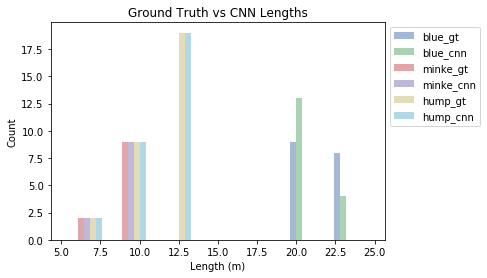

In [59]:
blue_gt = blues['Total Length (m)']
blue_cnn = blues['detected_len']

minke_gt = minkes['Total Length (m)']
minke_cnn = minkes['detected_len']

hump_gt = humpbacks['Total Length (m)']
hump_cnn = humpbacks['detected_len']

bins = np.linspace(5, 25, 8)

plt.style.use('seaborn-deep')

plt.xlabel('Length (m)')
plt.ylabel('Count')
plt.title('Ground Truth vs CNN Lengths')

plt.hist([blue_gt, blue_cnn, minke_gt, minke_cnn, hump_gt, hump_cnn], bins, alpha=0.5, 
         label=['blue_gt', 'blue_cnn', 'minke_gt', 'minke_cnn', 'hump_gt', 'hump_cnn'])


plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.savefig("hist_whales.png", dpi=512, bbox_inches='tight')

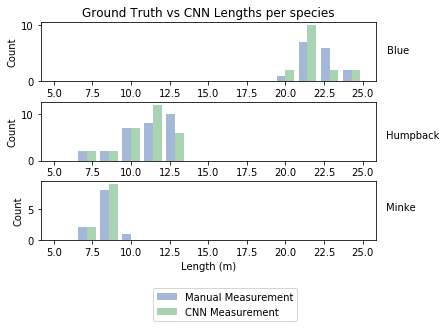

In [27]:
blue_gt = blues['Total Length (m)']
blue_cnn = blues['detected_len']

minke_gt = minkes['Total Length (m)']
minke_cnn = minkes['detected_len']

hump_gt = humpbacks['Total Length (m)']
hump_cnn = humpbacks['detected_len']

plt.xlabel('Length (m)')
plt.ylabel('Count')


bins = np.linspace(5, 25, 15)
#bins = range(6, 25)
plt.subplot(311)
plt.hist([blue_gt, blue_cnn], bins, alpha=0.5,  label=['Ground Truth Measurement', 'CNN Measurement'])
plt.title('Ground Truth vs CNN Lengths per species')
plt.xlabel('Length (m)')
plt.ylabel('Count')
#plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.text(26.6,6.5,"Blue", verticalalignment="top")

bins = np.linspace(5, 25, 15)
plt.subplot(312)
plt.hist([hump_gt, hump_cnn], bins, alpha=0.5, label=['Humpback Ground Truth', 'Humpback CNN'])
plt.xlabel('Length (m)')
plt.ylabel('Count')
#plt.legend(loc="upper right")
plt.text(26.5,6.5,"Humpback", verticalalignment="top")

bins = np.linspace(5, 25, 15)
plt.subplot(313)
plt.hist([minke_gt, minke_cnn], bins, alpha=0.5,label=['Manual Measurement', 'CNN Measurement'])
plt.xlabel('Length (m)')
plt.ylabel('Count')
plt.legend(loc="upper right", bbox_to_anchor=(.78,-.73))
plt.text(26.5,6,"Minke", verticalalignment="top")


plt.subplots_adjust(hspace=.35)

plt.savefig("hist_whales.png", dpi=512, bbox_inches='tight')

plt.show()

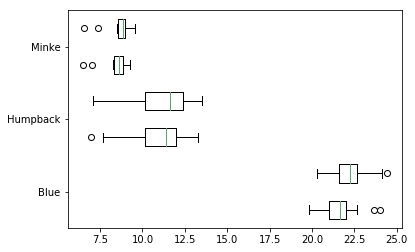

In [28]:
plt.boxplot([blue_cnn, blue_gt, hump_cnn, hump_gt, minke_cnn, minke_gt], vert=False)
plt.yticks([1.5, 3.5, 5.5], ['Blue', 'Humpback', 'Minke'])
plt.show()

In [29]:
hump_cnn.mean()

10.963185706862312

In [30]:
hump_gt.mean()

11.084482758620691

In [31]:
blue_cnn.mean()

21.71311160084311

In [32]:
blue_gt.mean()

22.235

In [33]:
minke_cnn.mean()

8.370029846141264

In [34]:
minke_gt.mean()

8.58

In [35]:
detection_df['Total Length (m)'].min()

6.54

In [36]:
detection_df['Total Length (m)'].max()

24.43

In [37]:
detection_df['detected_len'].min()


6.481145527536517

In [38]:
detection_df['detected_len'].max()

24.011561984108962

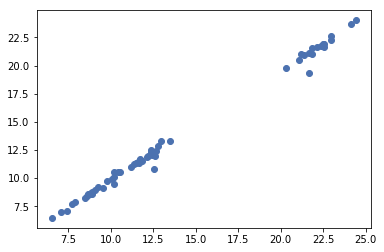

In [64]:
plt.scatter(detection_df['Total Length (m)'], detection_df['detected_len'])

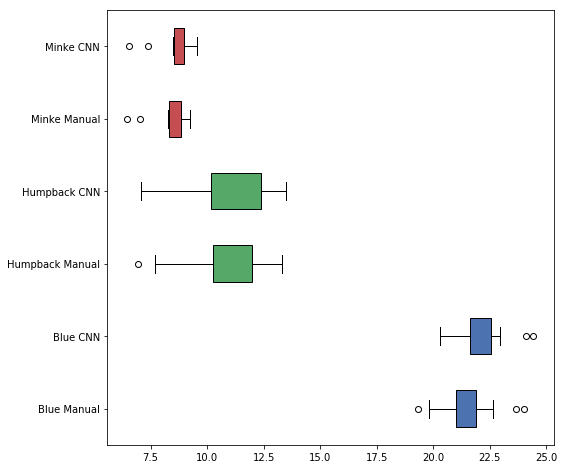

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

medianprops = dict(linewidth=0)

# rectangular box plot
bplot = axes.boxplot([blue_cnn, blue_gt, hump_cnn, hump_gt, minke_cnn, minke_gt],
                         vert=False,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         medianprops=medianprops) # eliminate median line

# fill with colors
colors = ['#4C72B0', '#4C72B0', '#55A868', '#55A868', '#C44E52', '#C44E52']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# add x-tick labels
plt.setp(axes, yticks=[y+1 for y in range(6)],
         yticklabels=['Blue Manual', 'Blue CNN', 'Humpback Manual', 'Humpback CNN', 'Minke Manual', 'Minke CNN'])

#plt.legend(loc='upper right')


plt.savefig("boxplot.png", dpi=512, bbox_inches='tight')
plt.show()

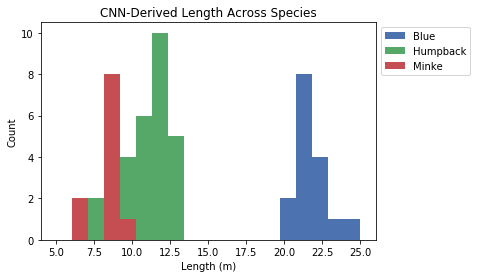

In [40]:
blue_gt = blues['Total Length (m)']
blue_cnn = blues['detected_len']

minke_gt = minkes['Total Length (m)']
minke_cnn = minkes['detected_len']

hump_gt = humpbacks['Total Length (m)']
hump_cnn = humpbacks['detected_len']

bins = np.linspace(5, 25, 20)

plt.style.use('seaborn-deep')

plt.xlabel('Length (m)')
plt.ylabel('Count')
plt.title('CNN-Derived Length Across Species')

plt.hist(blue_cnn, bins, alpha=1, label='Blue')
plt.hist(hump_cnn, bins, alpha=1, label='Humpback')
plt.hist(minke_cnn, bins, alpha=1, label='Minke')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig("hist_lengths.png", dpi=512, bbox_inches='tight')

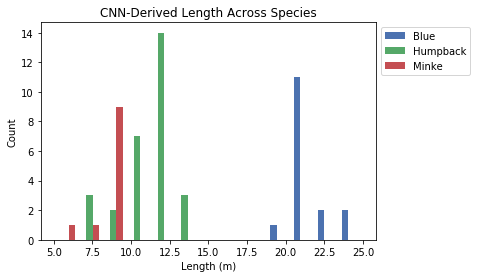

In [41]:
blue_gt = blues['Total Length (m)']
blue_cnn = blues['detected_len']

minke_gt = minkes['Total Length (m)']
minke_cnn = minkes['detected_len']

hump_gt = humpbacks['Total Length (m)']
hump_cnn = humpbacks['detected_len']

bins = np.linspace(5, 25, 14)

plt.style.use('seaborn-deep')

plt.xlabel('Length (m)')
plt.ylabel('Count')
plt.title('CNN-Derived Length Across Species')

plt.hist([blue_cnn, hump_cnn, minke_cnn], bins, alpha=1, label=['Blue', 'Humpback', 'Minke'])
#plt.hist(minke_cnn, bins, alpha=1, label='Minke')
#plt.hist(hump_cnn, bins, alpha=1, label='Humpback')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig("hist_lengths_cnn.png", dpi=512, bbox_inches='tight')

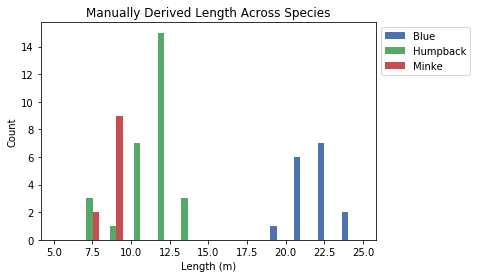

In [42]:
bins = np.linspace(5, 25, 14)

plt.style.use('seaborn-deep')

plt.xlabel('Length (m)')
plt.ylabel('Count')
plt.title('Manually Derived Length Across Species')

plt.hist([blue_gt, hump_gt, minke_gt], bins, alpha=1, label=['Blue', 'Humpback', 'Minke'])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig("hist_lengths_manual.png", dpi=512, bbox_inches='tight')

In [43]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']


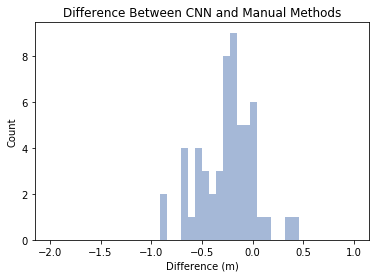

In [44]:
bins = np.linspace(-2, 1, 45)

#plt.style.use('seaborn-deep')

plt.xlabel('Difference (m)')
plt.ylabel('Count')
plt.title('Difference Between CNN and Manual Methods')

plt.hist(detection_df['detected_len'] - detection_df['Total Length (m)'], bins, alpha=0.5, label='Blue')
#plt.hist(minke_cnn, bins, alpha=0.5, label='Minke')
#plt.hist(hump_cnn, bins, alpha=0.5, label='Humpback')
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
#plt.savefig("hist_lengths.png", dpi=512, bbox_inches='tight')
plt.show()

## Debugging

0
355.9856347664867


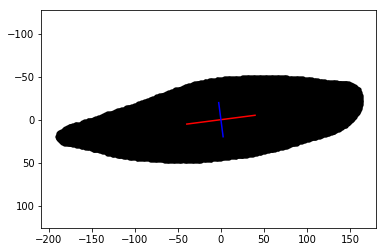

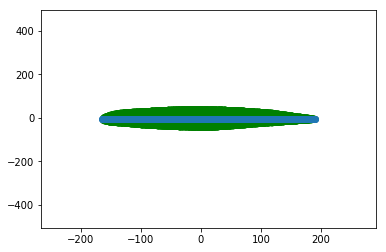

In [305]:
# TODO need to make sure that it is displaying the largest mask
for img in new_model_results:
    if img[1] == "DSC01317.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            show_example(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    


0
295.20642126209594
longest index:  0
1
longest index:  0
2
longest index:  0


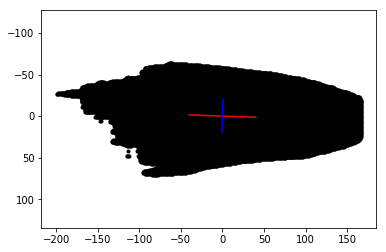

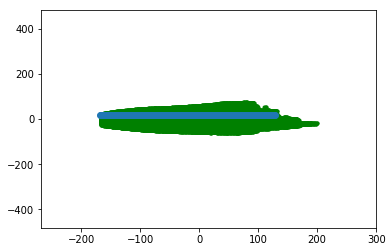

In [278]:
# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC01963.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)
                print('longest index: ', longest_index)

            show_example(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            print("indexerror")
            pass
        except TypeError: # also in case a detection was not made
            print("typeerror")
            pass
    


0
377.5352534207196


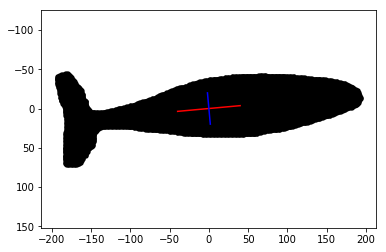

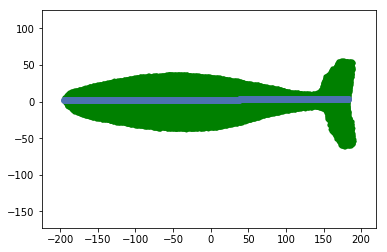

In [348]:
# TODO need to make sure that it is displaying the largest mask
for img in detection_results:
    if img[1] == "DSC02093.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            show_example(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    


0
189.9944298932187
1
218.08481854999272


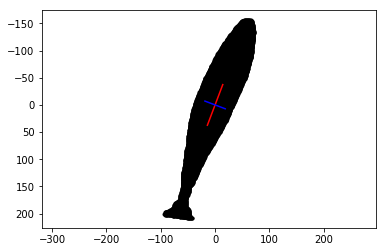

theta is:  0.989858787560261
[[ 0.54880791 -0.83594849]
 [ 0.83594849  0.54880791]]


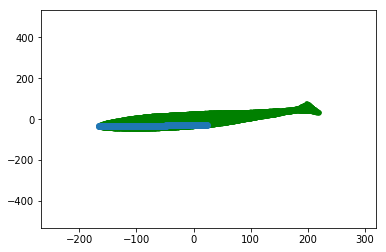

In [219]:

# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC09175.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            show_example(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    

0
384.83365246571077
1


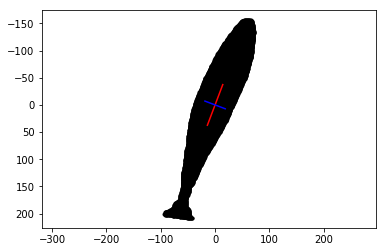

input for tanh:  2.639605696583299
input for tanh:  -0.3788444619946071
x_v1  0.3542733361087434
y_v1  -0.9351419161402088
theta is:  1.20909279877397
degrees are 69.275914409409
[[ 0.35386805 -0.93529536]
 [ 0.93529536  0.35386805]]


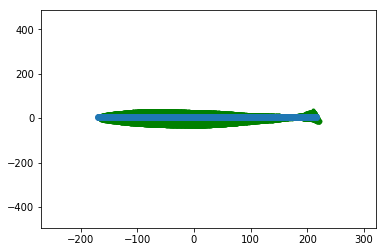

In [250]:

# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC09175.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            show_example(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    

DSC03331.JPG


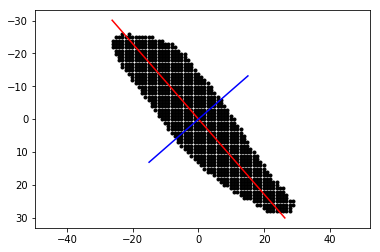

theta is:  -0.8160319617525315
degrees are -46.75518735620107
DSC03206.JPG


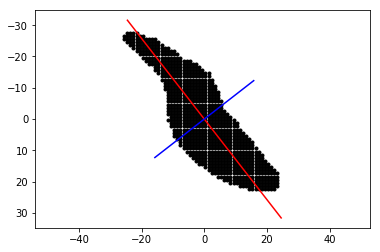

theta is:  -0.8579885830097806
degrees are -49.15912467687032
DSC03182.JPG


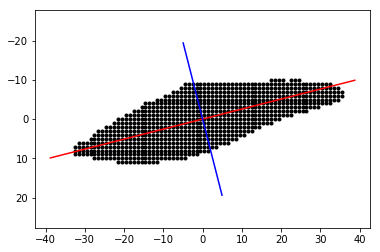

theta is:  0.2497086395925399
degrees are 14.307251156605904
DSC02689.JPG


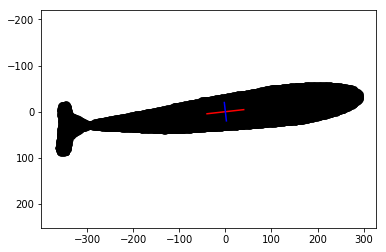

theta is:  0.11160879667758684
degrees are 6.394713006159451
DSC03868.JPG


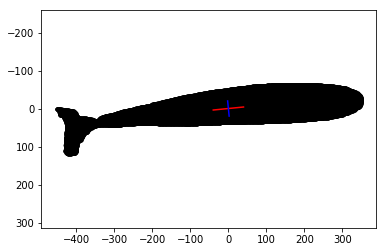

theta is:  0.09922361051043756
degrees are 5.685094110297988
DSC03795.JPG


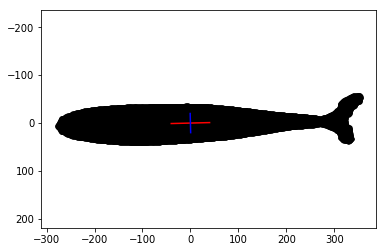

theta is:  0.024788595891115973
degrees are 1.4202819246162792
DSC03665.JPG


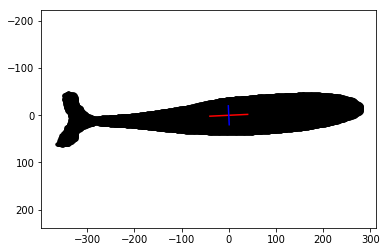

theta is:  0.04743868360982995
degrees are 2.718036356499689
DSC03996.JPG


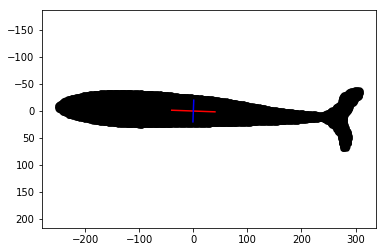

theta is:  -0.037029150486529334
degrees are -2.1216140418329297
DSC04110.JPG


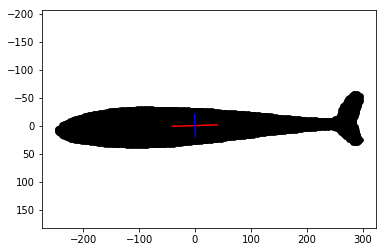

theta is:  0.03221353570660614
degrees are 1.8456996391825102
DSC04067.JPG


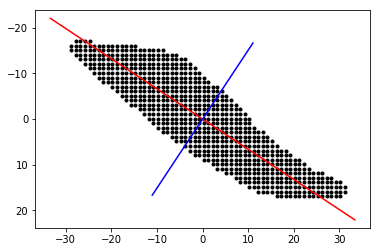

theta is:  -0.5795585743170065
degrees are -33.20626028898354
DSC04331.JPG


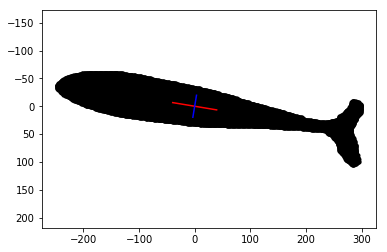

theta is:  -0.16408009634188472
degrees are -9.401097022489932
DSC04216.JPG


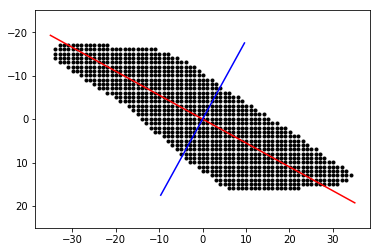

theta is:  -0.5007653796057105
degrees are -28.691742777673763
DSC04471.JPG


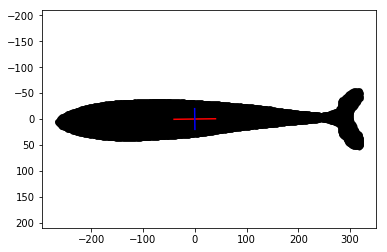

theta is:  0.013189275916129011
degrees are 0.7556898448277347
DSC04475.JPG


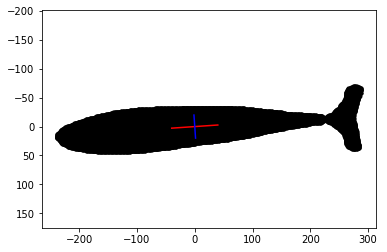

theta is:  0.06817199619430593
degrees are 3.9059676629156397
DSC04565.JPG


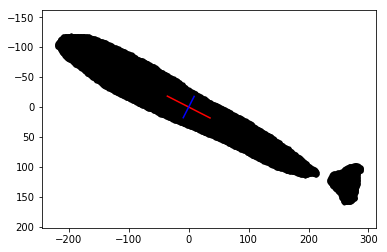

theta is:  -0.4709472810020713
degrees are -26.9832915745803
DSC04596.JPG


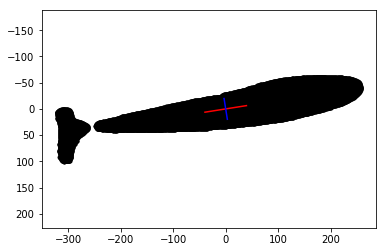

theta is:  0.15672926327327844
degrees are 8.979925311753592
DSC04578.JPG


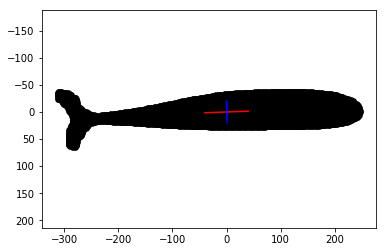

theta is:  0.03612269597547077
degrees are 2.0696780240286796
DSC00429.JPG


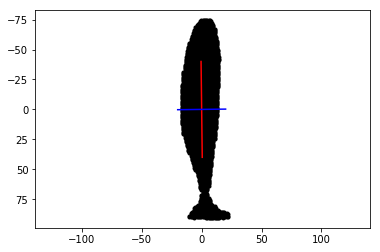

0.012407230062690936
0.7108819180400264
theta is:  1.5832035568575875
degrees are 90.71088191804003
[[-0.01240691 -0.99992303]
 [ 0.99992303 -0.01240691]]


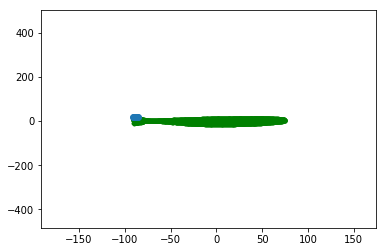

DSC09175.JPG


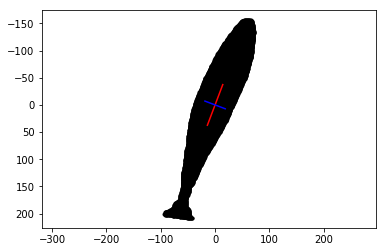

-0.3617035280209267
-20.72408559059101
theta is:  1.20909279877397
degrees are 69.275914409409
[[ 0.35386805 -0.93529536]
 [ 0.93529536  0.35386805]]


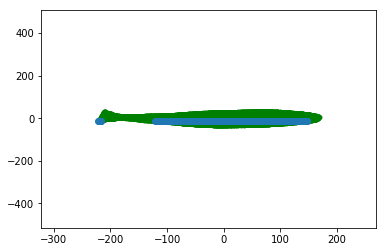

DSC09070.JPG


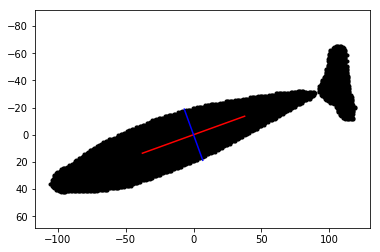

theta is:  0.3469232427450671
degrees are 19.8772376242849
DSC09056.JPG


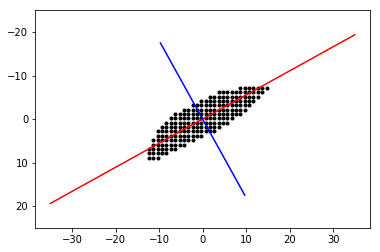

theta is:  0.5034942875942882
degrees are 28.848097688098793
DSC09026.JPG


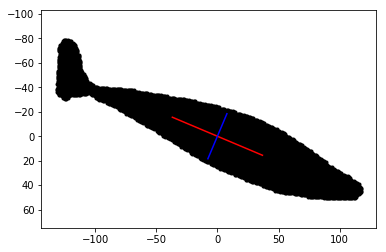

theta is:  -0.39879938675483007
degrees are -22.849521733457188
DSC09223.JPG


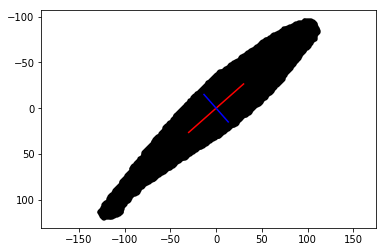

theta is:  0.7079870168477291
degrees are 40.56466801543239
DSC09219.JPG


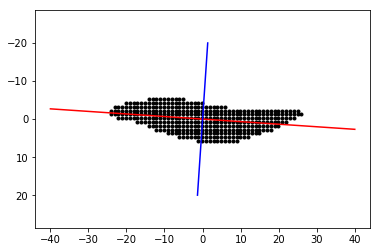

theta is:  -0.0671503331760629
degrees are -3.8474306838857175
DSC09242.JPG


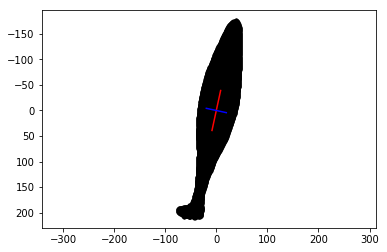

-0.21313267345351397
-12.21160266522631
theta is:  1.3576636533413826
degrees are 77.78839733477369
[[ 0.21152272 -0.97737308]
 [ 0.97737308  0.21152272]]


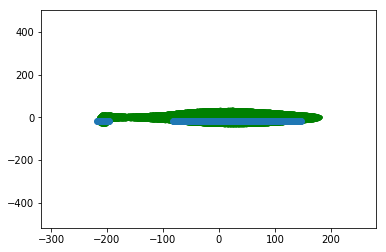

DSC09233.JPG


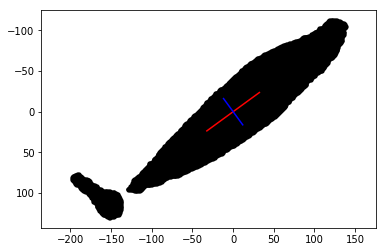

theta is:  0.6233737294323698
degrees are 35.716683755804894
DSC09329.JPG


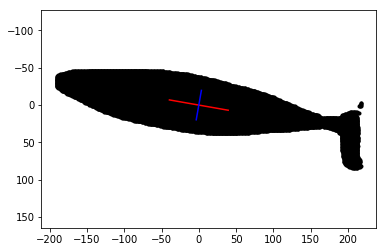

theta is:  -0.17369172838898075
degrees are -9.951802973021223
DSC09289.JPG


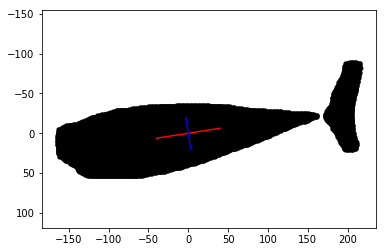

theta is:  0.1547810237296553
degrees are 8.868299408423493
DSC09258.JPG


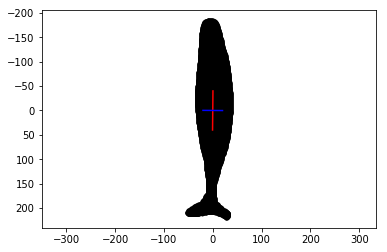

-0.0101545075490432
-0.5818104255939092
theta is:  1.5606418192458533
degrees are 89.41818957440609
[[ 0.01015433 -0.99994844]
 [ 0.99994844  0.01015433]]


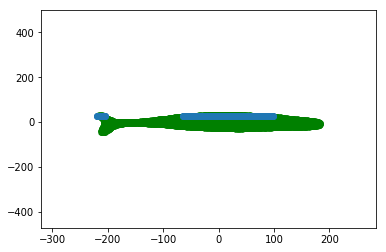

DSC09333.JPG


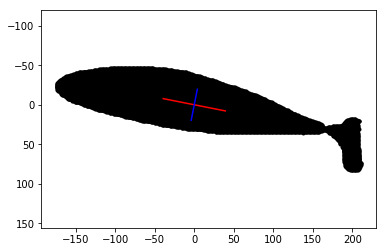

theta is:  -0.19538585212955176
degrees are -11.194784703590503
DSC09331.JPG


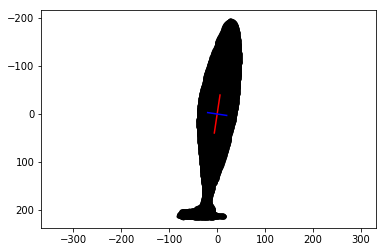

-0.14860998527624125
-8.51472494982993
theta is:  1.4221863415186553
degrees are 81.48527505017007
[[ 0.14806358 -0.98897784]
 [ 0.98897784  0.14806358]]


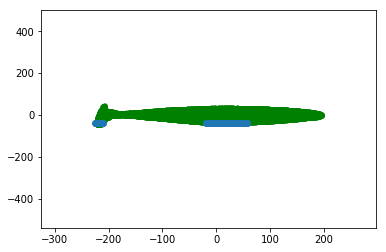

DSC05019.JPG


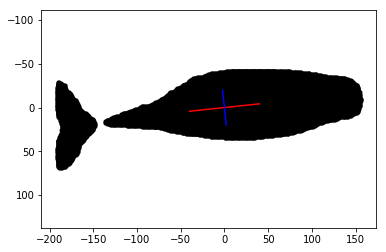

theta is:  0.1057585968909373
degrees are 6.059521249076098
DSC04952.JPG


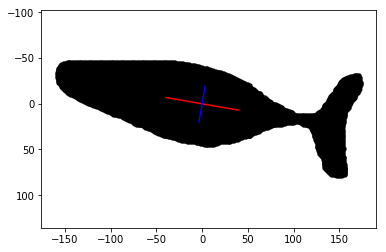

theta is:  -0.17224430947464
degrees are -9.86887197804209
DSC04947.JPG


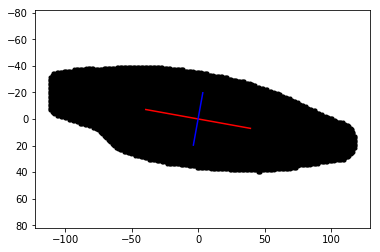

theta is:  -0.17816136817169012
degrees are -10.20789446851424
DSC04878.JPG


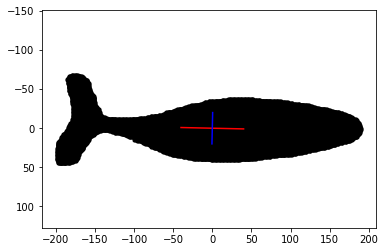

theta is:  -0.022084855343461215
degrees are -1.2653690023372717
DSC04872.JPG


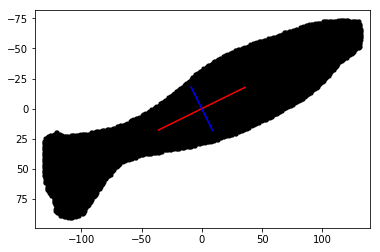

theta is:  0.4568288171228713
degrees are 26.174363181094243
DSC04863.JPG


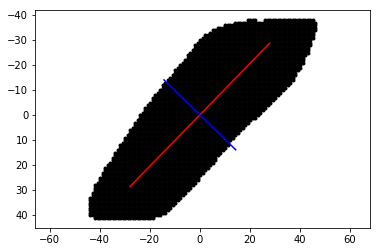

theta is:  0.7725487145284906
degrees are 44.263780810739576
DSC04832.JPG


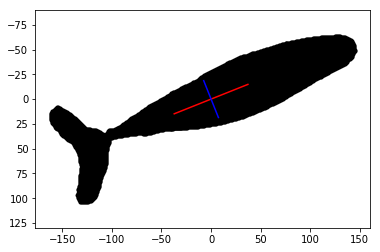

theta is:  0.37927896498679037
degrees are 21.73108395183321
DSC04798.JPG


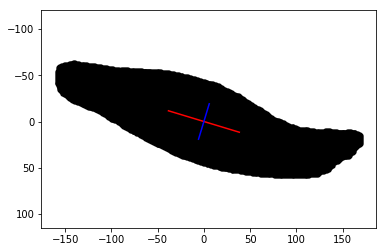

theta is:  -0.29370547235858196
degrees are -16.82808398604301
DSC04723.JPG


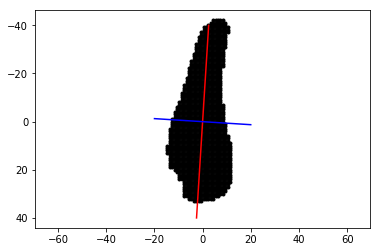

-0.06292363751681063
-3.6052588613242964
theta is:  1.507872689278086
degrees are 86.39474113867571
[[ 0.06288212 -0.99802096]
 [ 0.99802096  0.06288212]]


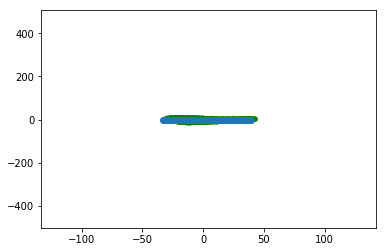

DSC03560.JPG


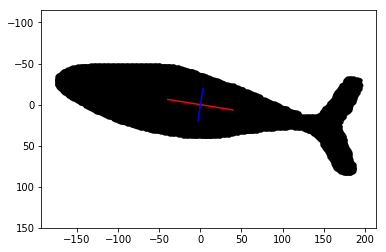

theta is:  -0.15911966477339337
degrees are -9.116885229051919
DSC03457.JPG


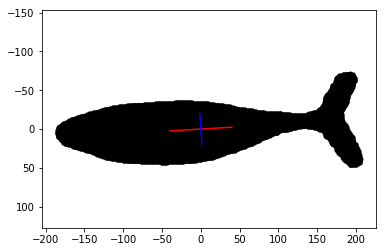

theta is:  0.060079689863897695
degrees are 3.4423126636562493
DSC02464.JPG


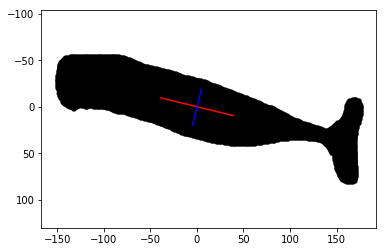

theta is:  -0.2396765660114979
degrees are -13.732455680647504
DSC02239.JPG


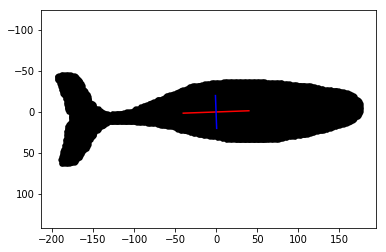

theta is:  0.03636797002892473
degrees are 2.0837311921156574
DSC02121.JPG


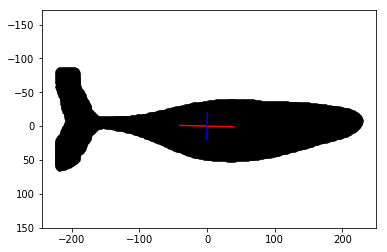

theta is:  -0.02630862427120296
degrees are -1.5073731355353708
DSC02093.JPG


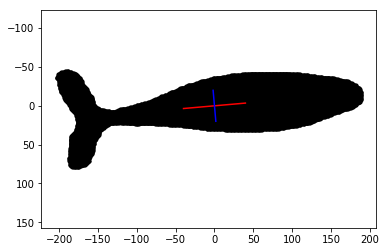

theta is:  0.08744316856768729
degrees are 5.010124506179501
DSC02035.JPG


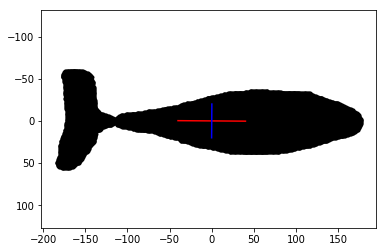

theta is:  -0.007343981016576607
degrees are -0.4207791170740354
DSC01963.JPG


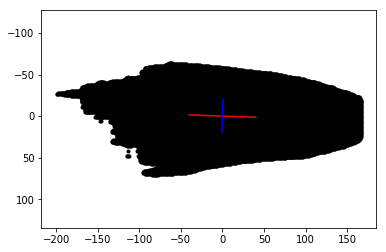

theta is:  -0.03592269135647372
degrees are -2.0582186034770262
DSC01615.JPG


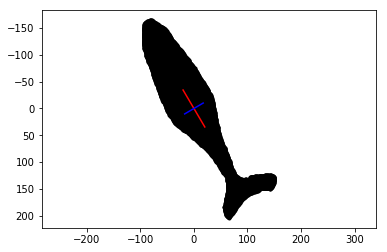

0.5286858455005757
30.291467635488495
theta is:  2.099482172295472
degrees are 120.29146763548849
[[-0.50439904 -0.86347067]
 [ 0.86347067 -0.50439904]]


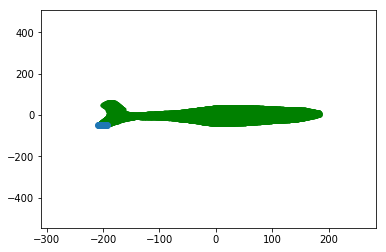

DSC01565.JPG


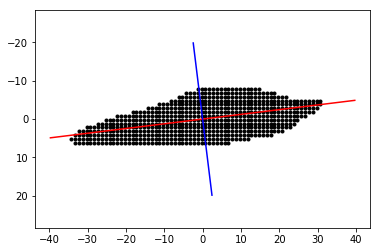

theta is:  0.12244671031674723
degrees are 7.015679716410611
DSC01506.JPG


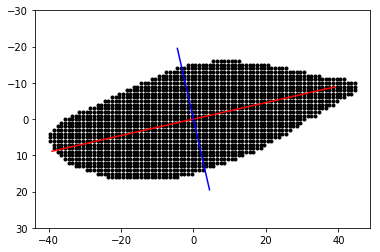

theta is:  0.22352815168522794
degrees are 12.80721969392364
DSC01426.JPG
DSC01317.JPG


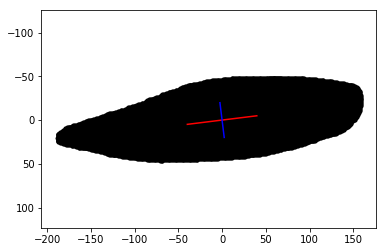

theta is:  0.12254910614421818
degrees are 7.0215465651644475
DSC01123.JPG


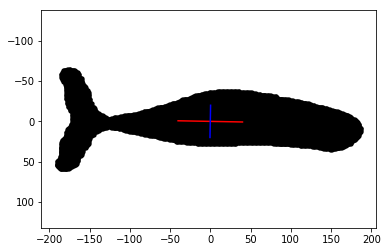

theta is:  -0.018551139117297336
degrees are -1.062901976581185
DSC01082.JPG


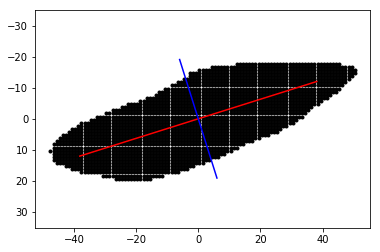

theta is:  0.30481833020381566
degrees are 17.464803838903745
DSC00948.JPG


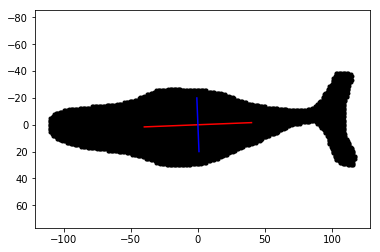

theta is:  0.039765501822256195
degrees are 2.278395424635064
DSC00833.JPG


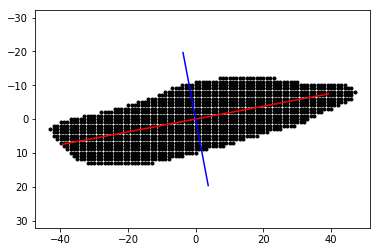

theta is:  0.1873341063473888
degrees are 10.733453652560305
DSC00660.JPG


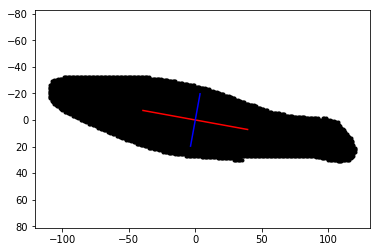

theta is:  -0.17976525714002956
degrees are -10.29979053720768
DSC00566.JPG


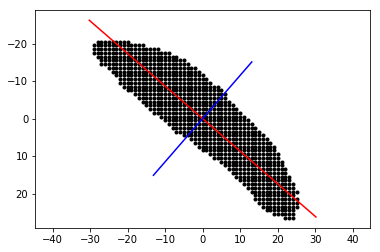

theta is:  -0.7003234851410887
degrees are -40.1255799924772
DSC00477.JPG


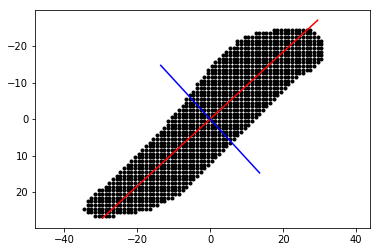

theta is:  0.7255200140625735
degrees are 41.5692347580576


In [225]:

# TODO need to make sure that it is displaying the largest mask
for index, img in enumerate(additional_results):
    print(img[1])
        
    try:
        longest_index = -1
        longest_length = 0
        for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
            #print(index)
            # take the longest mask
            if detection[1] > longest_length:
                longest_index = index
                longest_length = detection[1]
                #print(longest_length)

        show_example(img[0][0]['masks'][:,:,0], visualize=True)

    except IndexError: # in case a detection was not made
        pass
    except TypeError: # also in case a detection was not made
        pass
    